### Setup

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul 12 15:29:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    35W / 250W |    413MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


### Import Libraries

In [1]:
import tensorflow as tf
print(tf.__version__)

2.8.2


In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

In [5]:
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "white",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "grey",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

### Load Dataset

In [71]:
content_path = '/content/Patung_Pancoran_00000052.jpg'
style_path = '/content/cyberpunk-style-illustration-of-ding-ding-car-in-hong-kong-street-at-night_2983459.jpg'

style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')

### Pre-process the inputs

In [72]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

# Load the input images.
content_image = load_img(content_path)
style_image = load_img(style_path)

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Style Image Shape:', preprocessed_style_image.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

Style Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)


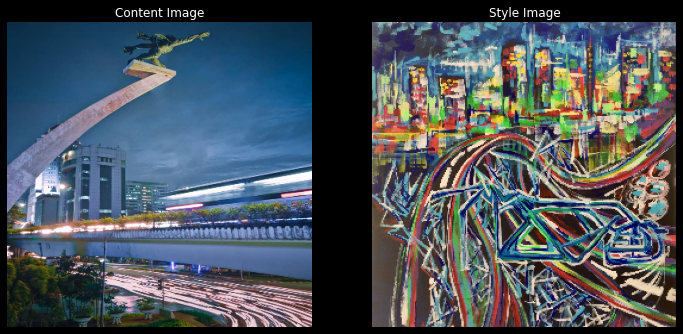

In [73]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.axis('off')
  plt.imshow(image)
  if title:
    plt.title(title)

plt.subplot(1, 2, 1)
plt.axis('off')
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 2, 2)
plt.axis('off')
imshow(preprocessed_style_image, 'Style Image')

### Style prediction and Style transform

In [74]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)

Style Bottleneck Shape: (1, 1, 1, 100)


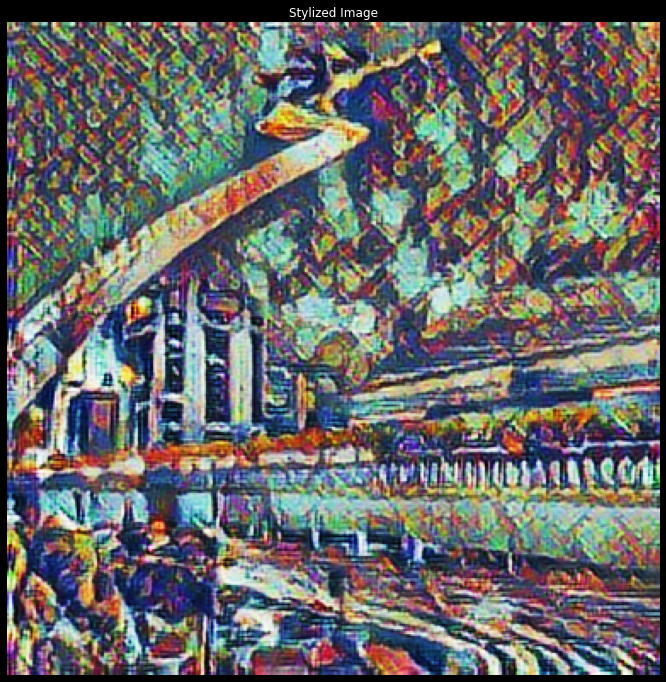

In [75]:
# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()

  # Set model inputs.
  interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image

# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)

# Visualize the output.
imshow(stylized_image, 'Stylized Image')

### Style blending

In [76]:
# Calculate style bottleneck of the content image.
style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256)
    )

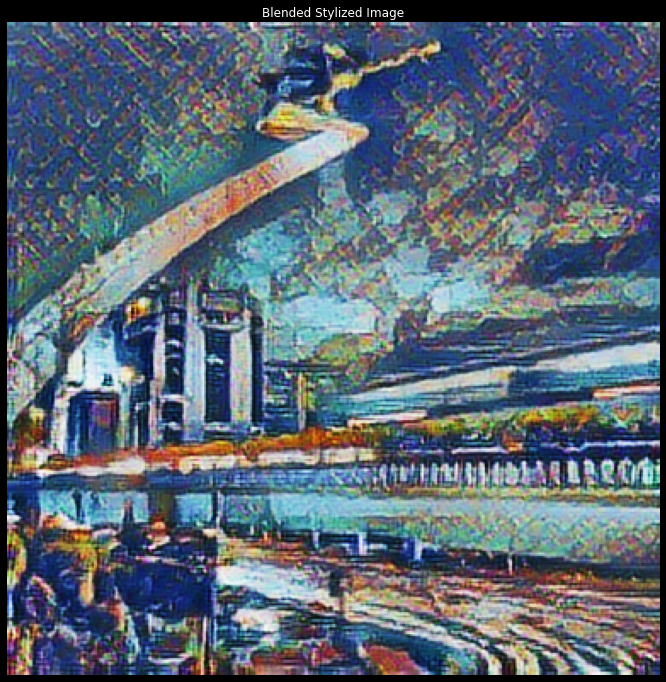

In [77]:
content_blending_ratio = 0.5

# Blend the style bottleneck of style image and content image
style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                           + (1 - content_blending_ratio) * style_bottleneck

# Stylize the content image using the style bottleneck.
stylized_image_blended = run_style_transform(style_bottleneck_blended,
                                             preprocessed_content_image)

# Visualize the output.
imshow(stylized_image_blended, 'Blended Stylized Image')

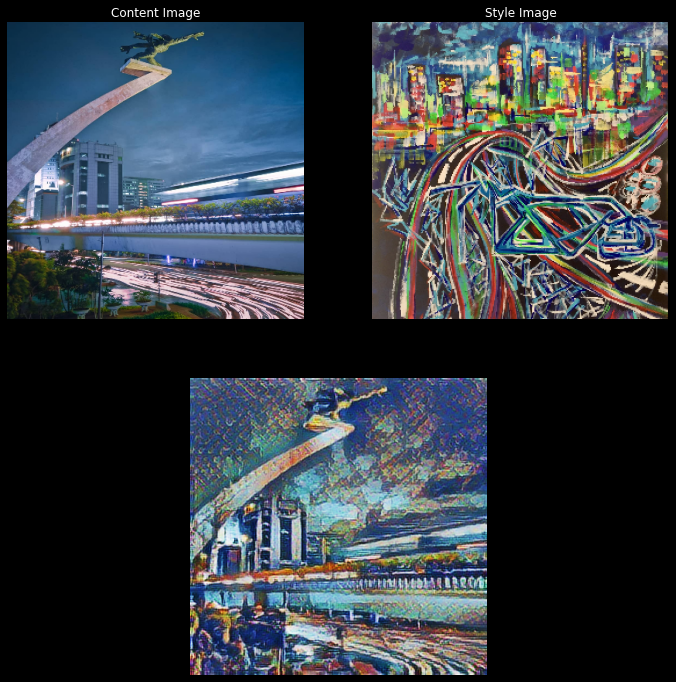

In [78]:
plt.subplot(2, 2, 1)
plt.axis('off')
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(2, 2, 2)
plt.axis('off')
imshow(preprocessed_style_image, 'Style Image')

plt.subplot(2, 1, 2)
plt.axis('off')
imshow(stylized_image_blended)

---